### Surrogate model building for smoothly varying v(z) model

---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from sciann import Functional, Variable, SciModel
from sciann.utils import *
import scipy.io 
import time
import random

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

Using TensorFlow backend.


---------------------- SCIANN 0.4.6.2 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



In [2]:
np.random.seed(123)
tf.random.set_seed(123)

In [3]:
#Model specifications

v0 = 2; # Velocity at the origin (0,0)
vergrad = 0.5; # Vertical gradient
horgrad = 0.; # Horizontal gradient

zmin = 0.; zmax = 2.; deltaz = 0.02;
xmin = 0.; xmax = 2.; deltax = 0.02;

z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size

Z,X = np.meshgrid(z,x,indexing='ij')

# Creating a mesh of sources
sz = np.array([0.2,0.7,1.3,1.8])
sx = np.array([0.2,0.7,1.3,1.8])

SZ,SX = np.meshgrid(sz,sx)

sz = SZ.reshape(-1,1)
sx = SX.reshape(-1,1)

# Velocity model for plotting
velmodel = v0 + vergrad*(Z-0.) + horgrad*(X-0.);


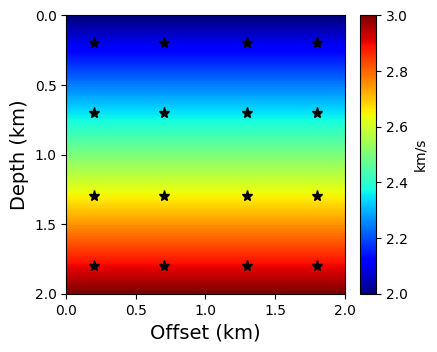

In [43]:
# Plot the velocity model
plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(velmodel, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vofz_surrogate/sources.pdf", format='pdf', bbox_inches="tight")

In [4]:
# Preparing necessary arrays for the sources

X_star, Z_star, SX_star, SZ_star, T_star, V_star = [[] for i in range(6)]

for ns, (szi, sxi) in enumerate(zip(sz, sx)):

    vs = v0 + vergrad*szi + + horgrad*sxi # Velocity at source point
    velmodel = vs + vergrad*(Z-szi) + horgrad*(X-sxi);

    T_data = np.arccosh(1.0+0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*((X-sxi)**2 + (Z-szi)**2))/np.sqrt(vergrad**2 + horgrad**2)

    X_star.append(X.reshape(-1, 1))
    Z_star.append(Z.reshape(-1, 1))
    SX_star.append(np.ones_like(X).reshape(-1,1)*sxi)
    SZ_star.append(np.ones_like(Z).reshape(-1,1)*szi)
    T_star.append(T_data.reshape(-1,1))
    V_star.append(velmodel.reshape(-1,1))


X_star = np.concatenate(X_star, axis=0)
Z_star = np.concatenate(Z_star, axis=0)
SX_star = np.concatenate(SX_star, axis=0)
SZ_star = np.concatenate(SZ_star, axis=0)
T_star = np.concatenate(T_star, axis=0)
V_star = np.concatenate(V_star, axis=0)

In [5]:
K.clear_session() 

layers = [40]*20

xt = Variable("xt")
zt = Variable("zt")
vt = Variable("vt")
sxt = Variable("sxt")
szt = Variable("szt")

tau = Functional("tau", [xt, zt, sxt, szt], layers, 'atan')

L = diff(tau, xt)**2 + diff(tau, zt)**2 - 1.0/vt**2


targets = [tau, L, (1-sign(tau))*abs(tau)]
target_vals = [T_star, 'zeros', 'zeros']

model = SciModel(
    [xt, zt, sxt, szt, vt], 
    targets
)

In [6]:
start_time = time.time()
hist = model.train(
    [X_star, Z_star, SX_star, SZ_star, V_star],
    target_vals, 
    batch_size=1000,
    epochs=2000,
    verbose=2,
    learning_rate=0.0003
    )
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

Epoch 1/2000
 - 6s - loss: 0.0666 - tau_loss: 0.0459 - sub/8_loss: 0.0206 - mul/12_loss: 6.8448e-05
Epoch 2/2000
 - 5s - loss: 0.0124 - tau_loss: 0.0061 - sub/8_loss: 0.0063 - mul/12_loss: 1.1209e-05
Epoch 3/2000
 - 5s - loss: 0.0038 - tau_loss: 6.3018e-04 - sub/8_loss: 0.0032 - mul/12_loss: 0.0000e+00
Epoch 4/2000
 - 5s - loss: 0.0025 - tau_loss: 3.7049e-04 - sub/8_loss: 0.0021 - mul/12_loss: 0.0000e+00
Epoch 5/2000
 - 5s - loss: 0.0013 - tau_loss: 1.6201e-04 - sub/8_loss: 0.0011 - mul/12_loss: 0.0000e+00
Epoch 6/2000
 - 5s - loss: 7.8288e-04 - tau_loss: 8.0255e-05 - sub/8_loss: 7.0241e-04 - mul/12_loss: 0.0000e+00
Epoch 7/2000
 - 5s - loss: 6.1015e-04 - tau_loss: 6.3142e-05 - sub/8_loss: 5.4728e-04 - mul/12_loss: 0.0000e+00
Epoch 8/2000
 - 5s - loss: 5.2191e-04 - tau_loss: 8.0857e-05 - sub/8_loss: 4.4163e-04 - mul/12_loss: 0.0000e+00
Epoch 9/2000
 - 5s - loss: 4.6517e-04 - tau_loss: 1.1148e-04 - sub/8_loss: 3.5284e-04 - mul/12_loss: 0.0000e+00
Epoch 10/2000
 - 5s - loss: 3.4421e-04 -

 - 5s - loss: 8.6161e-05 - tau_loss: 1.0857e-05 - sub/8_loss: 7.5449e-05 - mul/12_loss: 0.0000e+00
Epoch 75/2000
 - 7s - loss: 5.8317e-05 - tau_loss: 1.3942e-05 - sub/8_loss: 4.4340e-05 - mul/12_loss: 0.0000e+00
Epoch 76/2000
 - 4s - loss: 8.3881e-05 - tau_loss: 4.3906e-05 - sub/8_loss: 3.9672e-05 - mul/12_loss: 6.1937e-10
Epoch 77/2000
 - 5s - loss: 5.5263e-05 - tau_loss: 1.4839e-05 - sub/8_loss: 4.0601e-05 - mul/12_loss: 0.0000e+00
Epoch 78/2000
 - 7s - loss: 6.9445e-05 - tau_loss: 3.4032e-05 - sub/8_loss: 3.5707e-05 - mul/12_loss: 1.8431e-09
Epoch 79/2000
 - 4s - loss: 7.6232e-05 - tau_loss: 3.4246e-05 - sub/8_loss: 4.2312e-05 - mul/12_loss: 1.5214e-10
Epoch 80/2000
 - 5s - loss: 6.5425e-05 - tau_loss: 2.8854e-05 - sub/8_loss: 3.6353e-05 - mul/12_loss: 0.0000e+00
Epoch 81/2000
 - 5s - loss: 7.7361e-05 - tau_loss: 3.1954e-05 - sub/8_loss: 4.5107e-05 - mul/12_loss: 2.8316e-12
Epoch 82/2000
 - 7s - loss: 1.3157e-04 - tau_loss: 7.6594e-05 - sub/8_loss: 5.4466e-05 - mul/12_loss: 0.0000e+

Epoch 147/2000
 - 5s - loss: 3.9786e-05 - tau_loss: 2.2534e-05 - sub/8_loss: 1.7142e-05 - mul/12_loss: 3.1548e-10
Epoch 148/2000
 - 5s - loss: 2.9516e-05 - tau_loss: 1.6079e-05 - sub/8_loss: 1.3348e-05 - mul/12_loss: 0.0000e+00
Epoch 149/2000
 - 5s - loss: 3.2102e-05 - tau_loss: 1.9255e-05 - sub/8_loss: 1.2777e-05 - mul/12_loss: 3.2871e-11
Epoch 150/2000
 - 5s - loss: 4.1555e-05 - tau_loss: 2.2637e-05 - sub/8_loss: 1.8955e-05 - mul/12_loss: 0.0000e+00
Epoch 151/2000
 - 5s - loss: 3.6942e-05 - tau_loss: 2.3422e-05 - sub/8_loss: 1.3410e-05 - mul/12_loss: 8.3429e-10
Epoch 152/2000
 - 5s - loss: 1.9415e-05 - tau_loss: 9.6112e-06 - sub/8_loss: 1.0472e-05 - mul/12_loss: 0.0000e+00
Epoch 153/2000
 - 5s - loss: 3.0254e-05 - tau_loss: 1.7487e-05 - sub/8_loss: 1.2855e-05 - mul/12_loss: 0.0000e+00
Epoch 154/2000
 - 5s - loss: 3.3787e-05 - tau_loss: 1.9177e-05 - sub/8_loss: 1.5044e-05 - mul/12_loss: 1.6694e-09
Epoch 155/2000
 - 5s - loss: 4.0431e-05 - tau_loss: 2.4120e-05 - sub/8_loss: 1.6418e-05 

Epoch 219/2000
 - 5s - loss: 7.3621e-06 - tau_loss: 1.8832e-06 - sub/8_loss: 5.4627e-06 - mul/12_loss: 0.0000e+00
Epoch 220/2000
 - 5s - loss: 6.9665e-06 - tau_loss: 1.6445e-06 - sub/8_loss: 5.3349e-06 - mul/12_loss: 0.0000e+00
Epoch 221/2000
 - 5s - loss: 7.8574e-06 - tau_loss: 2.1710e-06 - sub/8_loss: 5.6660e-06 - mul/12_loss: 0.0000e+00
Epoch 222/2000
 - 5s - loss: 7.8884e-06 - tau_loss: 2.1362e-06 - sub/8_loss: 5.7628e-06 - mul/12_loss: 0.0000e+00
Epoch 223/2000
 - 5s - loss: 7.7465e-06 - tau_loss: 1.9965e-06 - sub/8_loss: 5.7998e-06 - mul/12_loss: 0.0000e+00
Epoch 224/2000
 - 5s - loss: 1.1908e-05 - tau_loss: 5.5155e-06 - sub/8_loss: 6.4298e-06 - mul/12_loss: 0.0000e+00
Epoch 225/2000
 - 5s - loss: 1.6724e-05 - tau_loss: 7.7226e-06 - sub/8_loss: 8.9431e-06 - mul/12_loss: 0.0000e+00
Epoch 226/2000
 - 5s - loss: 9.7594e-06 - tau_loss: 3.5279e-06 - sub/8_loss: 6.2411e-06 - mul/12_loss: 0.0000e+00
Epoch 227/2000
 - 5s - loss: 1.2168e-05 - tau_loss: 4.7002e-06 - sub/8_loss: 7.4895e-06 

Epoch 291/2000
 - 5s - loss: 9.6277e-06 - tau_loss: 4.8590e-06 - sub/8_loss: 4.7955e-06 - mul/12_loss: 0.0000e+00
Epoch 292/2000
 - 5s - loss: 1.0332e-05 - tau_loss: 4.8087e-06 - sub/8_loss: 5.4945e-06 - mul/12_loss: 0.0000e+00
Epoch 293/2000
 - 5s - loss: 1.1487e-05 - tau_loss: 5.2092e-06 - sub/8_loss: 6.2621e-06 - mul/12_loss: 0.0000e+00
Epoch 294/2000
 - 5s - loss: 1.2305e-05 - tau_loss: 6.1339e-06 - sub/8_loss: 6.1327e-06 - mul/12_loss: 0.0000e+00
Epoch 295/2000
 - 5s - loss: 5.9430e-06 - tau_loss: 1.7721e-06 - sub/8_loss: 4.1581e-06 - mul/12_loss: 0.0000e+00
Epoch 296/2000
 - 5s - loss: 1.2714e-05 - tau_loss: 5.7063e-06 - sub/8_loss: 6.9628e-06 - mul/12_loss: 1.3801e-11
Epoch 297/2000
 - 6s - loss: 1.1528e-05 - tau_loss: 5.2053e-06 - sub/8_loss: 6.2795e-06 - mul/12_loss: 8.9106e-13
Epoch 298/2000
 - 5s - loss: 1.0611e-05 - tau_loss: 4.5984e-06 - sub/8_loss: 5.9966e-06 - mul/12_loss: 0.0000e+00
Epoch 299/2000
 - 6s - loss: 1.3190e-05 - tau_loss: 5.7245e-06 - sub/8_loss: 7.7633e-06 

Epoch 363/2000
 - 5s - loss: 9.4197e-06 - tau_loss: 3.5818e-06 - sub/8_loss: 5.8662e-06 - mul/12_loss: 0.0000e+00
Epoch 364/2000
 - 5s - loss: 1.3308e-05 - tau_loss: 6.7364e-06 - sub/8_loss: 6.5398e-06 - mul/12_loss: 4.9366e-12
Epoch 365/2000
 - 5s - loss: 1.0860e-05 - tau_loss: 4.8840e-06 - sub/8_loss: 5.9578e-06 - mul/12_loss: 0.0000e+00
Epoch 366/2000
 - 5s - loss: 8.9775e-06 - tau_loss: 4.0741e-06 - sub/8_loss: 4.8906e-06 - mul/12_loss: 0.0000e+00
Epoch 367/2000
 - 5s - loss: 7.8705e-06 - tau_loss: 3.3270e-06 - sub/8_loss: 4.5290e-06 - mul/12_loss: 0.0000e+00
Epoch 368/2000
 - 6s - loss: 1.4097e-05 - tau_loss: 7.4238e-06 - sub/8_loss: 6.6281e-06 - mul/12_loss: 3.4125e-12
Epoch 369/2000
 - 5s - loss: 5.2053e-06 - tau_loss: 2.0630e-06 - sub/8_loss: 3.1326e-06 - mul/12_loss: 0.0000e+00
Epoch 370/2000
 - 5s - loss: 1.0787e-05 - tau_loss: 5.6598e-06 - sub/8_loss: 5.0979e-06 - mul/12_loss: 7.5862e-12
Epoch 371/2000
 - 5s - loss: 9.3958e-06 - tau_loss: 4.2007e-06 - sub/8_loss: 5.1714e-06 

Epoch 435/2000
 - 5s - loss: 1.0907e-05 - tau_loss: 4.8912e-06 - sub/8_loss: 5.9823e-06 - mul/12_loss: 0.0000e+00
Epoch 436/2000
 - 5s - loss: 8.8964e-06 - tau_loss: 3.8320e-06 - sub/8_loss: 5.0353e-06 - mul/12_loss: 0.0000e+00
Epoch 437/2000
 - 5s - loss: 8.7801e-06 - tau_loss: 4.2821e-06 - sub/8_loss: 4.4804e-06 - mul/12_loss: 8.9260e-12
Epoch 438/2000
 - 5s - loss: 9.8874e-06 - tau_loss: 5.2600e-06 - sub/8_loss: 4.6158e-06 - mul/12_loss: 0.0000e+00
Epoch 439/2000
 - 5s - loss: 6.0996e-06 - tau_loss: 3.0314e-06 - sub/8_loss: 3.0763e-06 - mul/12_loss: 0.0000e+00
Epoch 440/2000
 - 5s - loss: 1.0037e-05 - tau_loss: 4.6761e-06 - sub/8_loss: 5.3354e-06 - mul/12_loss: 5.2225e-11
Epoch 441/2000
 - 5s - loss: 7.6776e-06 - tau_loss: 4.2810e-06 - sub/8_loss: 3.3709e-06 - mul/12_loss: 0.0000e+00
Epoch 442/2000
 - 5s - loss: 9.6821e-06 - tau_loss: 4.7185e-06 - sub/8_loss: 4.9357e-06 - mul/12_loss: 0.0000e+00
Epoch 443/2000
 - 6s - loss: 7.7935e-06 - tau_loss: 3.5005e-06 - sub/8_loss: 4.2816e-06 

Epoch 507/2000
 - 5s - loss: 9.4403e-06 - tau_loss: 5.4512e-06 - sub/8_loss: 3.9813e-06 - mul/12_loss: 0.0000e+00
Epoch 508/2000
 - 5s - loss: 7.3554e-06 - tau_loss: 3.4306e-06 - sub/8_loss: 3.9129e-06 - mul/12_loss: 0.0000e+00
Epoch 509/2000
 - 6s - loss: 9.1507e-06 - tau_loss: 3.9047e-06 - sub/8_loss: 5.3300e-06 - mul/12_loss: 0.0000e+00
Epoch 510/2000
 - 6s - loss: 1.1234e-05 - tau_loss: 5.0407e-06 - sub/8_loss: 6.1756e-06 - mul/12_loss: 0.0000e+00
Epoch 511/2000
 - 5s - loss: 8.6658e-06 - tau_loss: 4.5676e-06 - sub/8_loss: 4.0891e-06 - mul/12_loss: 0.0000e+00
Epoch 512/2000
 - 5s - loss: 8.4337e-06 - tau_loss: 4.0274e-06 - sub/8_loss: 4.4113e-06 - mul/12_loss: 0.0000e+00
Epoch 513/2000
 - 5s - loss: 1.2371e-05 - tau_loss: 6.5273e-06 - sub/8_loss: 5.8197e-06 - mul/12_loss: 0.0000e+00
Epoch 514/2000
 - 5s - loss: 4.2842e-06 - tau_loss: 1.6121e-06 - sub/8_loss: 2.6613e-06 - mul/12_loss: 0.0000e+00
Epoch 515/2000
 - 5s - loss: 7.3017e-06 - tau_loss: 4.1182e-06 - sub/8_loss: 3.1645e-06 

Epoch 579/2000
 - 5s - loss: 1.4146e-05 - tau_loss: 7.5390e-06 - sub/8_loss: 6.6233e-06 - mul/12_loss: 2.9177e-12
Epoch 580/2000
 - 5s - loss: 6.7145e-06 - tau_loss: 2.6086e-06 - sub/8_loss: 4.0946e-06 - mul/12_loss: 0.0000e+00
Epoch 581/2000
 - 5s - loss: 9.0492e-06 - tau_loss: 4.4977e-06 - sub/8_loss: 4.6228e-06 - mul/12_loss: 4.7405e-11
Epoch 582/2000
 - 5s - loss: 1.0002e-05 - tau_loss: 4.8758e-06 - sub/8_loss: 5.1055e-06 - mul/12_loss: 4.3488e-11
Epoch 583/2000
 - 5s - loss: 6.8674e-06 - tau_loss: 3.3265e-06 - sub/8_loss: 3.5289e-06 - mul/12_loss: 0.0000e+00
Epoch 584/2000
 - 5s - loss: 6.7753e-06 - tau_loss: 3.5178e-06 - sub/8_loss: 3.2442e-06 - mul/12_loss: 0.0000e+00
Epoch 585/2000
 - 5s - loss: 8.7662e-06 - tau_loss: 4.2450e-06 - sub/8_loss: 4.5728e-06 - mul/12_loss: 0.0000e+00
Epoch 586/2000
 - 5s - loss: 1.9693e-05 - tau_loss: 1.0010e-05 - sub/8_loss: 9.6168e-06 - mul/12_loss: 0.0000e+00
Epoch 587/2000
 - 5s - loss: 5.3199e-06 - tau_loss: 1.6092e-06 - sub/8_loss: 3.6989e-06 

Epoch 651/2000
 - 6s - loss: 6.6376e-06 - tau_loss: 2.6363e-06 - sub/8_loss: 4.1239e-06 - mul/12_loss: 0.0000e+00
Epoch 652/2000
 - 6s - loss: 4.4921e-06 - tau_loss: 1.4694e-06 - sub/8_loss: 3.0090e-06 - mul/12_loss: 0.0000e+00
Epoch 653/2000
 - 5s - loss: 5.3984e-06 - tau_loss: 2.2774e-06 - sub/8_loss: 3.1064e-06 - mul/12_loss: 0.0000e+00
Epoch 654/2000
 - 5s - loss: 4.6954e-06 - tau_loss: 1.9712e-06 - sub/8_loss: 2.7179e-06 - mul/12_loss: 0.0000e+00
Epoch 655/2000
 - 6s - loss: 4.4225e-06 - tau_loss: 1.5371e-06 - sub/8_loss: 2.8859e-06 - mul/12_loss: 0.0000e+00
Epoch 656/2000
 - 5s - loss: 3.6119e-06 - tau_loss: 1.4570e-06 - sub/8_loss: 2.1533e-06 - mul/12_loss: 0.0000e+00
Epoch 657/2000
 - 5s - loss: 4.7875e-06 - tau_loss: 1.9772e-06 - sub/8_loss: 2.8613e-06 - mul/12_loss: 0.0000e+00
Epoch 658/2000
 - 6s - loss: 5.4186e-06 - tau_loss: 2.0213e-06 - sub/8_loss: 3.3894e-06 - mul/12_loss: 0.0000e+00
Epoch 659/2000
 - 5s - loss: 3.6803e-06 - tau_loss: 1.3285e-06 - sub/8_loss: 2.3567e-06 

Epoch 723/2000
 - 5s - loss: 5.8603e-06 - tau_loss: 2.4730e-06 - sub/8_loss: 3.3670e-06 - mul/12_loss: 0.0000e+00
Epoch 724/2000
 - 6s - loss: 3.0120e-06 - tau_loss: 1.2462e-06 - sub/8_loss: 1.7633e-06 - mul/12_loss: 0.0000e+00
Epoch 725/2000
 - 6s - loss: 2.8440e-06 - tau_loss: 1.2364e-06 - sub/8_loss: 1.6035e-06 - mul/12_loss: 0.0000e+00
Epoch 726/2000
 - 5s - loss: 4.1629e-06 - tau_loss: 1.5394e-06 - sub/8_loss: 2.6188e-06 - mul/12_loss: 0.0000e+00
Epoch 727/2000
 - 6s - loss: 2.7747e-06 - tau_loss: 1.2431e-06 - sub/8_loss: 1.5344e-06 - mul/12_loss: 0.0000e+00
Epoch 728/2000
 - 6s - loss: 4.6607e-06 - tau_loss: 1.9727e-06 - sub/8_loss: 2.6707e-06 - mul/12_loss: 0.0000e+00
Epoch 729/2000
 - 6s - loss: 4.2266e-06 - tau_loss: 1.5925e-06 - sub/8_loss: 2.6259e-06 - mul/12_loss: 0.0000e+00
Epoch 730/2000
 - 6s - loss: 5.4356e-06 - tau_loss: 2.0701e-06 - sub/8_loss: 3.3775e-06 - mul/12_loss: 0.0000e+00
Epoch 731/2000
 - 6s - loss: 4.9056e-06 - tau_loss: 1.8925e-06 - sub/8_loss: 2.9958e-06 

Epoch 795/2000
 - 5s - loss: 6.6381e-06 - tau_loss: 2.6758e-06 - sub/8_loss: 3.9689e-06 - mul/12_loss: 0.0000e+00
Epoch 796/2000
 - 5s - loss: 3.6750e-06 - tau_loss: 1.4437e-06 - sub/8_loss: 2.2322e-06 - mul/12_loss: 0.0000e+00
Epoch 797/2000
 - 5s - loss: 3.6125e-06 - tau_loss: 1.4632e-06 - sub/8_loss: 2.1387e-06 - mul/12_loss: 3.7023e-12
Epoch 798/2000
 - 5s - loss: 5.1725e-06 - tau_loss: 2.2947e-06 - sub/8_loss: 2.8590e-06 - mul/12_loss: 0.0000e+00
Epoch 799/2000
 - 5s - loss: 2.6396e-06 - tau_loss: 1.0337e-06 - sub/8_loss: 1.5989e-06 - mul/12_loss: 0.0000e+00
Epoch 800/2000
 - 5s - loss: 4.5565e-06 - tau_loss: 2.1013e-06 - sub/8_loss: 2.4454e-06 - mul/12_loss: 0.0000e+00
Epoch 801/2000
 - 5s - loss: 1.9324e-06 - tau_loss: 7.0348e-07 - sub/8_loss: 1.2272e-06 - mul/12_loss: 0.0000e+00
Epoch 802/2000
 - 5s - loss: 2.9965e-06 - tau_loss: 1.3162e-06 - sub/8_loss: 1.6837e-06 - mul/12_loss: 0.0000e+00
Epoch 803/2000
 - 5s - loss: 2.3852e-06 - tau_loss: 9.5139e-07 - sub/8_loss: 1.4287e-06 

Epoch 867/2000
 - 5s - loss: 5.5044e-06 - tau_loss: 2.1241e-06 - sub/8_loss: 3.3677e-06 - mul/12_loss: 0.0000e+00
Epoch 868/2000
 - 4s - loss: 3.8827e-06 - tau_loss: 1.1600e-06 - sub/8_loss: 2.7638e-06 - mul/12_loss: 0.0000e+00
Epoch 869/2000
 - 4s - loss: 3.3159e-06 - tau_loss: 1.4103e-06 - sub/8_loss: 1.9128e-06 - mul/12_loss: 0.0000e+00
Epoch 870/2000
 - 4s - loss: 4.4792e-06 - tau_loss: 1.9080e-06 - sub/8_loss: 2.5724e-06 - mul/12_loss: 0.0000e+00
Epoch 871/2000
 - 5s - loss: 3.4253e-06 - tau_loss: 1.2593e-06 - sub/8_loss: 2.1555e-06 - mul/12_loss: 0.0000e+00
Epoch 872/2000
 - 4s - loss: 4.1496e-06 - tau_loss: 1.8410e-06 - sub/8_loss: 2.3772e-06 - mul/12_loss: 0.0000e+00
Epoch 873/2000
 - 4s - loss: 5.8488e-06 - tau_loss: 2.2797e-06 - sub/8_loss: 3.5591e-06 - mul/12_loss: 0.0000e+00
Epoch 874/2000
 - 5s - loss: 6.0247e-06 - tau_loss: 2.3155e-06 - sub/8_loss: 3.6990e-06 - mul/12_loss: 0.0000e+00
Epoch 875/2000
 - 5s - loss: 2.7922e-06 - tau_loss: 9.9500e-07 - sub/8_loss: 1.8056e-06 

Epoch 939/2000
 - 4s - loss: 4.9649e-06 - tau_loss: 2.0018e-06 - sub/8_loss: 2.9469e-06 - mul/12_loss: 0.0000e+00
Epoch 940/2000
 - 4s - loss: 6.1142e-06 - tau_loss: 1.8830e-06 - sub/8_loss: 4.2098e-06 - mul/12_loss: 0.0000e+00
Epoch 941/2000
 - 4s - loss: 4.1984e-06 - tau_loss: 1.5398e-06 - sub/8_loss: 2.6637e-06 - mul/12_loss: 0.0000e+00
Epoch 942/2000
 - 4s - loss: 2.8628e-06 - tau_loss: 1.0683e-06 - sub/8_loss: 1.7963e-06 - mul/12_loss: 0.0000e+00
Epoch 943/2000
 - 5s - loss: 5.2536e-06 - tau_loss: 2.1200e-06 - sub/8_loss: 3.1523e-06 - mul/12_loss: 2.7150e-14
Epoch 944/2000
 - 5s - loss: 2.4539e-06 - tau_loss: 9.7000e-07 - sub/8_loss: 1.4755e-06 - mul/12_loss: 0.0000e+00
Epoch 945/2000
 - 4s - loss: 5.4428e-06 - tau_loss: 2.2784e-06 - sub/8_loss: 3.1433e-06 - mul/12_loss: 0.0000e+00
Epoch 946/2000
 - 4s - loss: 2.5940e-06 - tau_loss: 9.8197e-07 - sub/8_loss: 1.6051e-06 - mul/12_loss: 0.0000e+00
Epoch 947/2000
 - 5s - loss: 5.9647e-06 - tau_loss: 2.6197e-06 - sub/8_loss: 3.3202e-06 

Epoch 1011/2000
 - 4s - loss: 3.9409e-06 - tau_loss: 1.4590e-06 - sub/8_loss: 2.4732e-06 - mul/12_loss: 0.0000e+00
Epoch 1012/2000
 - 4s - loss: 3.4588e-06 - tau_loss: 1.2496e-06 - sub/8_loss: 2.2381e-06 - mul/12_loss: 0.0000e+00

Epoch 01012: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
Epoch 1013/2000
 - 4s - loss: 2.0715e-06 - tau_loss: 6.4928e-07 - sub/8_loss: 1.4147e-06 - mul/12_loss: 0.0000e+00
Epoch 1014/2000
 - 4s - loss: 1.2287e-06 - tau_loss: 3.1144e-07 - sub/8_loss: 9.1495e-07 - mul/12_loss: 0.0000e+00
Epoch 1015/2000
 - 4s - loss: 1.7345e-06 - tau_loss: 6.5777e-07 - sub/8_loss: 1.0726e-06 - mul/12_loss: 0.0000e+00
Epoch 1016/2000
 - 5s - loss: 8.1301e-07 - tau_loss: 2.1640e-07 - sub/8_loss: 5.9458e-07 - mul/12_loss: 0.0000e+00
Epoch 1017/2000
 - 4s - loss: 1.2620e-06 - tau_loss: 3.6469e-07 - sub/8_loss: 8.9577e-07 - mul/12_loss: 0.0000e+00
Epoch 1018/2000
 - 4s - loss: 1.8153e-06 - tau_loss: 5.3782e-07 - sub/8_loss: 1.2981e-06 - mul/12_loss: 0.0000e+0

Epoch 1082/2000
 - 4s - loss: 8.7108e-07 - tau_loss: 2.9315e-07 - sub/8_loss: 5.8204e-07 - mul/12_loss: 0.0000e+00
Epoch 1083/2000
 - 4s - loss: 1.0092e-06 - tau_loss: 3.7702e-07 - sub/8_loss: 6.3268e-07 - mul/12_loss: 0.0000e+00
Epoch 1084/2000
 - 4s - loss: 2.6333e-06 - tau_loss: 9.8137e-07 - sub/8_loss: 1.6892e-06 - mul/12_loss: 0.0000e+00
Epoch 1085/2000
 - 4s - loss: 3.3311e-06 - tau_loss: 1.2196e-06 - sub/8_loss: 2.0983e-06 - mul/12_loss: 0.0000e+00
Epoch 1086/2000
 - 4s - loss: 8.3258e-07 - tau_loss: 2.6099e-07 - sub/8_loss: 5.7093e-07 - mul/12_loss: 0.0000e+00
Epoch 1087/2000
 - 4s - loss: 2.3569e-06 - tau_loss: 7.7312e-07 - sub/8_loss: 1.5761e-06 - mul/12_loss: 0.0000e+00
Epoch 1088/2000
 - 4s - loss: 8.8180e-07 - tau_loss: 2.6854e-07 - sub/8_loss: 6.1381e-07 - mul/12_loss: 0.0000e+00
Epoch 1089/2000
 - 4s - loss: 2.4371e-06 - tau_loss: 8.3254e-07 - sub/8_loss: 1.6009e-06 - mul/12_loss: 0.0000e+00
Epoch 1090/2000
 - 5s - loss: 1.2849e-06 - tau_loss: 3.9434e-07 - sub/8_loss: 8.

Epoch 1154/2000
 - 4s - loss: 1.9067e-06 - tau_loss: 6.8492e-07 - sub/8_loss: 1.2173e-06 - mul/12_loss: 0.0000e+00
Epoch 1155/2000
 - 4s - loss: 5.6445e-06 - tau_loss: 2.0104e-06 - sub/8_loss: 3.9892e-06 - mul/12_loss: 0.0000e+00
Epoch 1156/2000
 - 4s - loss: 3.6491e-06 - tau_loss: 1.4876e-06 - sub/8_loss: 2.1487e-06 - mul/12_loss: 0.0000e+00
Epoch 1157/2000
 - 4s - loss: 1.2439e-06 - tau_loss: 3.7884e-07 - sub/8_loss: 8.7235e-07 - mul/12_loss: 0.0000e+00
Epoch 1158/2000
 - 4s - loss: 9.3611e-07 - tau_loss: 2.8462e-07 - sub/8_loss: 6.4978e-07 - mul/12_loss: 0.0000e+00
Epoch 1159/2000
 - 4s - loss: 1.2280e-06 - tau_loss: 3.9386e-07 - sub/8_loss: 8.3212e-07 - mul/12_loss: 0.0000e+00
Epoch 1160/2000
 - 4s - loss: 9.1602e-07 - tau_loss: 3.1393e-07 - sub/8_loss: 5.9979e-07 - mul/12_loss: 4.3951e-14
Epoch 1161/2000
 - 4s - loss: 1.9481e-06 - tau_loss: 6.4719e-07 - sub/8_loss: 1.2943e-06 - mul/12_loss: 0.0000e+00
Epoch 1162/2000
 - 4s - loss: 7.3409e-07 - tau_loss: 2.7219e-07 - sub/8_loss: 4.

Epoch 1226/2000
 - 4s - loss: 2.8969e-06 - tau_loss: 1.2256e-06 - sub/8_loss: 1.6620e-06 - mul/12_loss: 0.0000e+00
Epoch 1227/2000
 - 4s - loss: 8.3777e-07 - tau_loss: 2.6793e-07 - sub/8_loss: 5.6943e-07 - mul/12_loss: 0.0000e+00
Epoch 1228/2000
 - 4s - loss: 9.2320e-07 - tau_loss: 3.1631e-07 - sub/8_loss: 6.0455e-07 - mul/12_loss: 0.0000e+00
Epoch 1229/2000
 - 4s - loss: 7.4284e-07 - tau_loss: 2.3662e-07 - sub/8_loss: 5.0509e-07 - mul/12_loss: 0.0000e+00
Epoch 1230/2000
 - 4s - loss: 1.1843e-06 - tau_loss: 4.2914e-07 - sub/8_loss: 7.5342e-07 - mul/12_loss: 0.0000e+00
Epoch 1231/2000
 - 4s - loss: 5.6706e-06 - tau_loss: 2.1128e-06 - sub/8_loss: 3.5479e-06 - mul/12_loss: 0.0000e+00
Epoch 1232/2000
 - 4s - loss: 1.2967e-06 - tau_loss: 4.1186e-07 - sub/8_loss: 8.8348e-07 - mul/12_loss: 0.0000e+00
Epoch 1233/2000
 - 4s - loss: 4.4169e-06 - tau_loss: 2.1083e-06 - sub/8_loss: 2.2937e-06 - mul/12_loss: 0.0000e+00
Epoch 1234/2000
 - 4s - loss: 1.5010e-06 - tau_loss: 4.4723e-07 - sub/8_loss: 1.

Epoch 1298/2000
 - 4s - loss: 7.5226e-06 - tau_loss: 2.5127e-06 - sub/8_loss: 4.9810e-06 - mul/12_loss: 0.0000e+00
Epoch 1299/2000
 - 4s - loss: 1.7006e-06 - tau_loss: 5.4491e-07 - sub/8_loss: 1.1525e-06 - mul/12_loss: 0.0000e+00
Epoch 1300/2000
 - 4s - loss: 4.2115e-06 - tau_loss: 1.4758e-06 - sub/8_loss: 2.7212e-06 - mul/12_loss: 0.0000e+00
Epoch 1301/2000
 - 4s - loss: 1.9699e-06 - tau_loss: 6.5546e-07 - sub/8_loss: 1.3142e-06 - mul/12_loss: 0.0000e+00
Epoch 1302/2000
 - 4s - loss: 1.5167e-06 - tau_loss: 5.8772e-07 - sub/8_loss: 9.3412e-07 - mul/12_loss: 0.0000e+00
Epoch 1303/2000
 - 4s - loss: 2.0345e-06 - tau_loss: 6.5324e-07 - sub/8_loss: 1.3759e-06 - mul/12_loss: 0.0000e+00
Epoch 1304/2000
 - 4s - loss: 1.5082e-06 - tau_loss: 4.5921e-07 - sub/8_loss: 1.0485e-06 - mul/12_loss: 0.0000e+00
Epoch 1305/2000
 - 4s - loss: 3.6031e-06 - tau_loss: 1.2331e-06 - sub/8_loss: 2.3580e-06 - mul/12_loss: 0.0000e+00
Epoch 1306/2000
 - 4s - loss: 1.1620e-06 - tau_loss: 3.6372e-07 - sub/8_loss: 7.

Epoch 1370/2000
 - 5s - loss: 8.4903e-06 - tau_loss: 2.9367e-06 - sub/8_loss: 5.5398e-06 - mul/12_loss: 0.0000e+00
Epoch 1371/2000
 - 5s - loss: 3.9837e-06 - tau_loss: 1.2605e-06 - sub/8_loss: 2.7118e-06 - mul/12_loss: 0.0000e+00
Epoch 1372/2000
 - 5s - loss: 1.7679e-06 - tau_loss: 5.9751e-07 - sub/8_loss: 1.1659e-06 - mul/12_loss: 0.0000e+00
Epoch 1373/2000
 - 5s - loss: 1.3482e-06 - tau_loss: 4.0882e-07 - sub/8_loss: 9.4057e-07 - mul/12_loss: 0.0000e+00
Epoch 1374/2000
 - 5s - loss: 1.2597e-06 - tau_loss: 4.0028e-07 - sub/8_loss: 8.5600e-07 - mul/12_loss: 0.0000e+00
Epoch 1375/2000
 - 5s - loss: 6.6821e-07 - tau_loss: 2.2236e-07 - sub/8_loss: 4.4621e-07 - mul/12_loss: 0.0000e+00
Epoch 1376/2000
 - 5s - loss: 5.6023e-07 - tau_loss: 2.0367e-07 - sub/8_loss: 3.5708e-07 - mul/12_loss: 0.0000e+00
Epoch 1377/2000
 - 5s - loss: 1.2089e-06 - tau_loss: 4.6625e-07 - sub/8_loss: 7.5031e-07 - mul/12_loss: 0.0000e+00
Epoch 1378/2000
 - 5s - loss: 2.8163e-06 - tau_loss: 6.6230e-07 - sub/8_loss: 2.

Epoch 1441/2000
 - 6s - loss: 5.8402e-07 - tau_loss: 1.5168e-07 - sub/8_loss: 4.3298e-07 - mul/12_loss: 0.0000e+00
Epoch 1442/2000
 - 6s - loss: 4.9065e-07 - tau_loss: 1.3749e-07 - sub/8_loss: 3.5396e-07 - mul/12_loss: 0.0000e+00
Epoch 1443/2000
 - 6s - loss: 4.2295e-07 - tau_loss: 1.0813e-07 - sub/8_loss: 3.1407e-07 - mul/12_loss: 0.0000e+00
Epoch 1444/2000
 - 6s - loss: 4.3610e-07 - tau_loss: 1.1905e-07 - sub/8_loss: 3.1695e-07 - mul/12_loss: 0.0000e+00
Epoch 1445/2000
 - 6s - loss: 4.6992e-07 - tau_loss: 1.2898e-07 - sub/8_loss: 3.4046e-07 - mul/12_loss: 0.0000e+00
Epoch 1446/2000
 - 6s - loss: 5.2866e-07 - tau_loss: 1.6124e-07 - sub/8_loss: 3.6870e-07 - mul/12_loss: 0.0000e+00
Epoch 1447/2000
 - 6s - loss: 1.0404e-06 - tau_loss: 3.5397e-07 - sub/8_loss: 6.8268e-07 - mul/12_loss: 0.0000e+00
Epoch 1448/2000
 - 6s - loss: 4.8510e-07 - tau_loss: 1.2393e-07 - sub/8_loss: 3.6175e-07 - mul/12_loss: 0.0000e+00
Epoch 1449/2000
 - 6s - loss: 9.7393e-07 - tau_loss: 2.7173e-07 - sub/8_loss: 7.

Epoch 1513/2000
 - 6s - loss: 5.4884e-07 - tau_loss: 1.4445e-07 - sub/8_loss: 4.0400e-07 - mul/12_loss: 0.0000e+00
Epoch 1514/2000
 - 6s - loss: 4.7265e-07 - tau_loss: 1.1913e-07 - sub/8_loss: 3.5319e-07 - mul/12_loss: 0.0000e+00
Epoch 1515/2000
 - 6s - loss: 6.0593e-07 - tau_loss: 1.6413e-07 - sub/8_loss: 4.4105e-07 - mul/12_loss: 0.0000e+00
Epoch 1516/2000
 - 6s - loss: 6.9094e-07 - tau_loss: 2.4028e-07 - sub/8_loss: 4.4934e-07 - mul/12_loss: 0.0000e+00
Epoch 1517/2000
 - 6s - loss: 3.8050e-07 - tau_loss: 9.6408e-08 - sub/8_loss: 2.8428e-07 - mul/12_loss: 0.0000e+00
Epoch 1518/2000
 - 6s - loss: 4.2092e-07 - tau_loss: 1.2179e-07 - sub/8_loss: 2.9915e-07 - mul/12_loss: 0.0000e+00
Epoch 1519/2000
 - 6s - loss: 4.1364e-07 - tau_loss: 1.1160e-07 - sub/8_loss: 3.0141e-07 - mul/12_loss: 0.0000e+00
Epoch 1520/2000
 - 6s - loss: 4.0856e-07 - tau_loss: 1.2020e-07 - sub/8_loss: 2.8855e-07 - mul/12_loss: 0.0000e+00
Epoch 1521/2000
 - 6s - loss: 4.8229e-07 - tau_loss: 1.4935e-07 - sub/8_loss: 3.

Epoch 1585/2000
 - 6s - loss: 3.9733e-07 - tau_loss: 1.1234e-07 - sub/8_loss: 2.8449e-07 - mul/12_loss: 0.0000e+00
Epoch 1586/2000
 - 6s - loss: 3.8436e-07 - tau_loss: 1.1153e-07 - sub/8_loss: 2.7207e-07 - mul/12_loss: 0.0000e+00
Epoch 1587/2000
 - 6s - loss: 4.6401e-07 - tau_loss: 1.3716e-07 - sub/8_loss: 3.2655e-07 - mul/12_loss: 0.0000e+00
Epoch 1588/2000
 - 6s - loss: 1.1909e-06 - tau_loss: 3.5667e-07 - sub/8_loss: 8.5936e-07 - mul/12_loss: 0.0000e+00
Epoch 1589/2000
 - 6s - loss: 1.3428e-06 - tau_loss: 4.0405e-07 - sub/8_loss: 9.3436e-07 - mul/12_loss: 0.0000e+00
Epoch 1590/2000
 - 6s - loss: 6.2809e-07 - tau_loss: 2.0017e-07 - sub/8_loss: 4.2646e-07 - mul/12_loss: 0.0000e+00
Epoch 1591/2000
 - 6s - loss: 3.9445e-07 - tau_loss: 1.0488e-07 - sub/8_loss: 2.8898e-07 - mul/12_loss: 0.0000e+00
Epoch 1592/2000
 - 6s - loss: 3.6741e-07 - tau_loss: 8.8588e-08 - sub/8_loss: 2.7831e-07 - mul/12_loss: 0.0000e+00
Epoch 1593/2000
 - 5s - loss: 3.5812e-07 - tau_loss: 9.6497e-08 - sub/8_loss: 2.

Epoch 1657/2000
 - 5s - loss: 3.7327e-07 - tau_loss: 1.1818e-07 - sub/8_loss: 2.5438e-07 - mul/12_loss: 0.0000e+00
Epoch 1658/2000
 - 5s - loss: 3.3820e-07 - tau_loss: 1.0615e-07 - sub/8_loss: 2.3158e-07 - mul/12_loss: 0.0000e+00
Epoch 1659/2000
 - 5s - loss: 1.1391e-06 - tau_loss: 3.5097e-07 - sub/8_loss: 7.8449e-07 - mul/12_loss: 2.4527e-12
Epoch 1660/2000
 - 5s - loss: 9.7449e-07 - tau_loss: 2.5864e-07 - sub/8_loss: 7.1309e-07 - mul/12_loss: 0.0000e+00
Epoch 1661/2000
 - 7s - loss: 3.9834e-07 - tau_loss: 9.0222e-08 - sub/8_loss: 3.0743e-07 - mul/12_loss: 0.0000e+00
Epoch 1662/2000
 - 5s - loss: 3.4082e-07 - tau_loss: 9.6600e-08 - sub/8_loss: 2.4397e-07 - mul/12_loss: 0.0000e+00
Epoch 1663/2000
 - 5s - loss: 4.4218e-07 - tau_loss: 1.4301e-07 - sub/8_loss: 2.9888e-07 - mul/12_loss: 0.0000e+00
Epoch 1664/2000
 - 5s - loss: 6.0867e-06 - tau_loss: 2.1453e-06 - sub/8_loss: 3.9508e-06 - mul/12_loss: 5.2505e-13
Epoch 1665/2000
 - 6s - loss: 3.8882e-06 - tau_loss: 8.0544e-07 - sub/8_loss: 3.

Epoch 1729/2000
 - 5s - loss: 4.3305e-07 - tau_loss: 1.2307e-07 - sub/8_loss: 3.0928e-07 - mul/12_loss: 0.0000e+00
Epoch 1730/2000
 - 5s - loss: 3.7684e-07 - tau_loss: 9.2084e-08 - sub/8_loss: 2.8565e-07 - mul/12_loss: 0.0000e+00
Epoch 1731/2000
 - 4s - loss: 4.2208e-07 - tau_loss: 1.1817e-07 - sub/8_loss: 3.0374e-07 - mul/12_loss: 0.0000e+00
Epoch 1732/2000
 - 5s - loss: 4.5830e-07 - tau_loss: 1.4901e-07 - sub/8_loss: 3.0922e-07 - mul/12_loss: 0.0000e+00
Epoch 1733/2000
 - 5s - loss: 3.7762e-07 - tau_loss: 1.0328e-07 - sub/8_loss: 2.7397e-07 - mul/12_loss: 0.0000e+00
Epoch 1734/2000
 - 5s - loss: 3.5164e-07 - tau_loss: 9.6662e-08 - sub/8_loss: 2.5447e-07 - mul/12_loss: 0.0000e+00
Epoch 1735/2000
 - 5s - loss: 5.0752e-07 - tau_loss: 1.5473e-07 - sub/8_loss: 3.5479e-07 - mul/12_loss: 0.0000e+00
Epoch 1736/2000
 - 5s - loss: 2.7957e-06 - tau_loss: 8.9272e-07 - sub/8_loss: 1.8923e-06 - mul/12_loss: 0.0000e+00
Epoch 1737/2000
 - 5s - loss: 4.6177e-07 - tau_loss: 1.1184e-07 - sub/8_loss: 3.

Epoch 1801/2000
 - 5s - loss: 5.7094e-07 - tau_loss: 1.4501e-07 - sub/8_loss: 4.2465e-07 - mul/12_loss: 0.0000e+00
Epoch 1802/2000
 - 4s - loss: 4.8280e-07 - tau_loss: 1.4826e-07 - sub/8_loss: 3.3379e-07 - mul/12_loss: 0.0000e+00
Epoch 1803/2000
 - 4s - loss: 3.6618e-07 - tau_loss: 1.0017e-07 - sub/8_loss: 2.6543e-07 - mul/12_loss: 0.0000e+00
Epoch 1804/2000
 - 5s - loss: 3.4698e-07 - tau_loss: 9.9367e-08 - sub/8_loss: 2.4717e-07 - mul/12_loss: 0.0000e+00
Epoch 1805/2000
 - 4s - loss: 4.1003e-07 - tau_loss: 1.2301e-07 - sub/8_loss: 2.8699e-07 - mul/12_loss: 0.0000e+00
Epoch 1806/2000
 - 4s - loss: 3.5820e-07 - tau_loss: 1.0283e-07 - sub/8_loss: 2.5478e-07 - mul/12_loss: 0.0000e+00
Epoch 1807/2000
 - 4s - loss: 8.3399e-07 - tau_loss: 2.5105e-07 - sub/8_loss: 5.8120e-07 - mul/12_loss: 0.0000e+00
Epoch 1808/2000
 - 4s - loss: 1.6429e-06 - tau_loss: 4.2815e-07 - sub/8_loss: 1.2175e-06 - mul/12_loss: 0.0000e+00
Epoch 1809/2000
 - 4s - loss: 5.5691e-07 - tau_loss: 1.5165e-07 - sub/8_loss: 4.

Epoch 1872/2000
 - 4s - loss: 3.2860e-07 - tau_loss: 8.7657e-08 - sub/8_loss: 2.4055e-07 - mul/12_loss: 0.0000e+00
Epoch 1873/2000
 - 4s - loss: 2.5858e-07 - tau_loss: 6.3331e-08 - sub/8_loss: 1.9596e-07 - mul/12_loss: 0.0000e+00
Epoch 1874/2000
 - 4s - loss: 2.5864e-07 - tau_loss: 6.0205e-08 - sub/8_loss: 1.9814e-07 - mul/12_loss: 0.0000e+00
Epoch 1875/2000
 - 4s - loss: 2.6438e-07 - tau_loss: 6.5709e-08 - sub/8_loss: 1.9853e-07 - mul/12_loss: 0.0000e+00
Epoch 1876/2000
 - 4s - loss: 2.7246e-07 - tau_loss: 6.6869e-08 - sub/8_loss: 2.0586e-07 - mul/12_loss: 0.0000e+00
Epoch 1877/2000
 - 5s - loss: 2.4714e-07 - tau_loss: 5.6289e-08 - sub/8_loss: 1.9087e-07 - mul/12_loss: 0.0000e+00
Epoch 1878/2000
 - 5s - loss: 2.5779e-07 - tau_loss: 6.3566e-08 - sub/8_loss: 1.9396e-07 - mul/12_loss: 0.0000e+00
Epoch 1879/2000
 - 4s - loss: 2.5876e-07 - tau_loss: 6.2047e-08 - sub/8_loss: 1.9650e-07 - mul/12_loss: 0.0000e+00
Epoch 1880/2000
 - 5s - loss: 2.7094e-07 - tau_loss: 6.7353e-08 - sub/8_loss: 2.

Epoch 1944/2000
 - 4s - loss: 2.3462e-07 - tau_loss: 5.6068e-08 - sub/8_loss: 1.7848e-07 - mul/12_loss: 0.0000e+00
Epoch 1945/2000
 - 5s - loss: 2.4506e-07 - tau_loss: 6.0386e-08 - sub/8_loss: 1.8471e-07 - mul/12_loss: 0.0000e+00
Epoch 1946/2000
 - 4s - loss: 2.6170e-07 - tau_loss: 6.3567e-08 - sub/8_loss: 1.9782e-07 - mul/12_loss: 0.0000e+00
Epoch 1947/2000
 - 4s - loss: 2.4355e-07 - tau_loss: 5.9042e-08 - sub/8_loss: 1.8454e-07 - mul/12_loss: 0.0000e+00
Epoch 1948/2000
 - 5s - loss: 2.3628e-07 - tau_loss: 5.4647e-08 - sub/8_loss: 1.8139e-07 - mul/12_loss: 0.0000e+00
Epoch 1949/2000
 - 4s - loss: 2.4621e-07 - tau_loss: 5.8842e-08 - sub/8_loss: 1.8724e-07 - mul/12_loss: 0.0000e+00
Epoch 1950/2000
 - 5s - loss: 2.6585e-07 - tau_loss: 6.3906e-08 - sub/8_loss: 2.0200e-07 - mul/12_loss: 0.0000e+00
Epoch 1951/2000
 - 5s - loss: 2.4478e-07 - tau_loss: 5.9970e-08 - sub/8_loss: 1.8471e-07 - mul/12_loss: 0.0000e+00
Epoch 1952/2000
 - 5s - loss: 2.3661e-07 - tau_loss: 5.6831e-08 - sub/8_loss: 1.

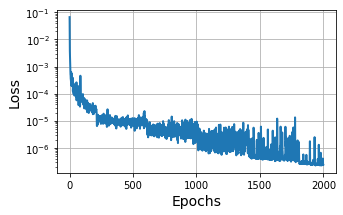

In [7]:
# Convergence history plot for verification

fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.semilogy(hist.history['loss'],LineWidth=2)

ax.set_xlabel('Epochs',fontsize=14)

plt.xticks(fontsize=10)
ax.xaxis.set_major_locator(plt.MultipleLocator(500))

ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=10);
plt.grid()

In [8]:
# Selecting a source position for testing

np.random.seed(123)
sz = np.round(np.random.uniform(zmin,zmax),decimals=2)
sx = np.round(np.random.uniform(xmin,xmax),decimals=2)

print(sx)
print(sz)

0.57
1.39


In [11]:
T_pred = tau.eval(model, [X, Z, np.ones_like(X)*sx, np.ones_like(X)*sz, velmodel])
T_pred[int(round(sz/deltaz)),int(round(sx/deltax))] = 0.

In [9]:
vs = v0 + vergrad*sz + horgrad*sx
T_data = np.arccosh(1.0+0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*((X-sx)**2 + (Z-sz)**2))/np.sqrt(vergrad**2 + horgrad**2)

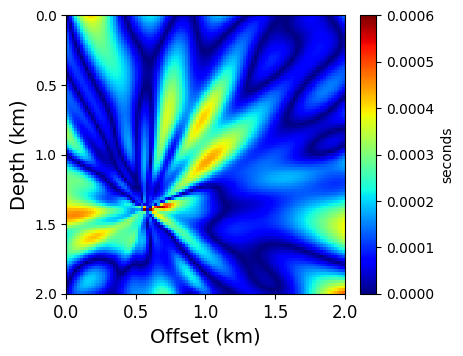

In [12]:
# Plot the computed tau

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_pred-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=12)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(0,0.0006)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vofz_surrogate/pinnerror.pdf", format='pdf', bbox_inches="tight")

In [13]:
# Loading fast marching solutions

# First order FMM solution
time_fmm1="data/fmm_or1_vofz_s(0.57,1.39).txt"

T_fmm1 = pd.read_csv(time_fmm1, index_col=None, header=None)
T_fmm1 = np.reshape(np.array(T_fmm1), (201, 201)).T
T_fmm1 = T_fmm1[::2,::2]

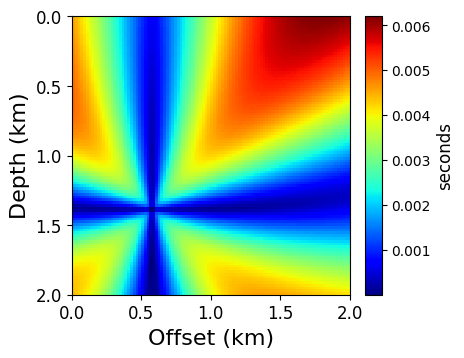

In [14]:
# Plot the computed tau

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_fmm1-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Offset (km)', fontsize=16)
plt.xticks(fontsize=12)

plt.ylabel('Depth (km)', fontsize=16)
plt.yticks(fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=12)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vofz_surrogate/fmm1error.pdf", format='pdf', bbox_inches="tight")

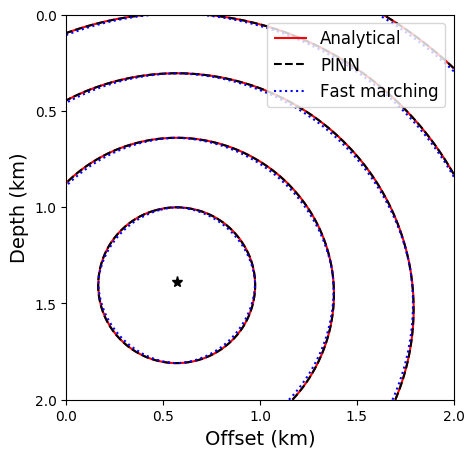

In [15]:
# Traveltime contour plots

plt.figure(figsize=(5,5))

ax = plt.gca()
im1 = ax.contour(T_data, 6, extent=[xmin,xmax,zmin,zmax], colors='r')
im2 = ax.contour(T_pred, 6, extent=[xmin,xmax,zmin,zmax], colors='k',linestyles = 'dashed')
im3 = ax.contour(T_fmm1, 6, extent=[xmin,xmax,zmin,zmax], colors='b',linestyles = 'dotted')

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0], h3[0]], ['Analytical', 'PINN', 'Fast marching'],fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.savefig("./figs/vofz_surrogate/contours.pdf", format='pdf', bbox_inches="tight")